In [1]:
import numpy as np
import pandas as pd

import sklearn.model_selection
import sklearn.preprocessing

import scipy.signal as signal
import scipy.interpolate as interpolate
import scipy.optimize as optimize

import seaborn as sns

from IPython.display import display

from eis.EISDataIO import eis_dataframe_from_csv

import lightgbm as lgb

from os import path
import logging

In [2]:
# loading training data

# if you are on a windows machine un-comment the following line to get the path to training data
# here = !echo %cd%

# if you are on a mac/ unix machine un-comment the following line to get the path to training data
here = !pwd

train_data_path = path.join(path.dirname(here[0]), "train_data.csv")
eis_data = eis_dataframe_from_csv(train_data_path)

# Reclasification

We ran a LightGBM model with the given labels and got ~45% accuracy. Thus, we decided to try different reclasification approaches according to what was discussed during the Q&As about the ambiguity of the original "9-labels" classification, such as `Kmeans` and `Gaussian Mixture`. The idea with this was see if the data itself could be separated in more general classes that the ones that were given. This route didn't take us anywhere as most of the samples were classified in the same group.

At the end, we decided to go for a reclasification of labels looking for the most parcimonious ECMs, as follows:

In [3]:
reclasification = {
    "L-R-RCPE": "0",
    "L-R-RCPE-RCPE": "0",
    "L-R-RCPE-RCPE-RCPE": "0",
    "RC-G-G": "1",
    "RC-RC-RCPE-RCPE": "2",
    "RCPE-RCPE": "2",
    "RCPE-RCPE-RCPE": "2",
    "RCPE-RCPE-RCPE-RCPE": "2",
    "Rs_Ws": "3"
}
inverse_reclasification = {
    "0": "L-R-RCPE",
    "1": "RC-G-G",
    "2": "RCPE-RCPE",
    "3": "Rs_Ws"
}

In [4]:
eis_data["circuit_recla"] = eis_data["Circuit"].map(reclasification)

In [5]:
def complex_parts(cmp: pd.Series) -> tuple[pd.Series, pd.Series]:
    real_part= cmp.apply(np.real)
    imag_part= cmp.apply(np.imag)
    return (real_part, imag_part)

eis_data["Z_real"], eis_data["Z_imag"] = complex_parts(eis_data.Z)
display(eis_data.head())

,freq,Z,Circuit,Parameters,circuit_recla,Z_real,Z_imag
0,"[0.1, 0.148398179, 0.220220195, 0.326802759, 0...","[(309.82561192-156.06088233j), (267.46983919-1...",L-R-RCPE-RCPE-RCPE,"L1: 2.94e-08, R1: 4.51e+00, R2: 5.19e-02, CPE1...",0,"[309.82561192, 267.46983919, 229.38061493, 196...","[-156.06088233, -146.21033646, -133.4855237, -..."
1,"[1.0, 1.34339933, 1.80472177, 2.42446202, 3.25...","[(344.50700012-0.87321496j), (344.36191597-0.9...",RC-RC-RCPE-RCPE,"R1: 2.08e+02, R2: 2.50e+01, R3: 9.57e+01, R4: ...",2,"[344.50700012, 344.36191597, 344.19647198, 344...","[-0.87321496, -0.99738889, -1.13909869, -1.300..."
2,"[1.0, 1.26360956, 1.59670912, 2.01761691, 2.54...","[(3080.15920083-80.84202473j), (3071.83539583-...",L-R-RCPE-RCPE-RCPE,"L1: 3.35e-08, R1: 6.95e+01, R2: 7.49e+01, CPE1...",0,"[3080.15920083, 3071.83539583, 3061.93812951, ...","[-80.84202473, -94.50641483, -110.36642266, -1..."
3,"[10.0, 13.4990445, 18.2224203, 24.5985264, 33....","[(930.93345951-0.0068507146j), (930.93327153-0...",L-R-RCPE,"L1: 8.43e-07, R1: 9.06e+01, R2: 8.40e+02, CPE1...",0,"[930.93345951, 930.93327153, 930.93302176, 930...","[-0.0068507146, -0.00910185162, -0.0120927041,..."
4,"[0.01, 0.0148907532, 0.0221734532, 0.033017942...","[(405.07355219-0.0149508921j), (405.07110253-0...",RCPE-RCPE-RCPE,"R1: 1.03e+01, R2: 6.71e-01, R3: 3.94e+02, CPE1...",2,"[405.07355219, 405.07110253, 405.06786553, 405...","[-0.0149508921, -0.0197551995, -0.026103215, -..."


# Feature extraction

First, we interpolated these two mappings: frequency-to-Z_real and frequency-to-Z_imaginary. Then, we numerically computed the first and second derivatives. 

The idea with this feature extraction was to make notable points such as maxima, minima, inflection points and straight lines, more evident. 

In [6]:
def nth_derivatives(x: np.array, y: np.array, n: int = 1) -> list[np.array]:
    this_der = y
    res = [this_der]
    for i in range(n):
        nth = i+1
        this_der = numerical_derivative(x, this_der)
        res.append(this_der)
    return res

In [7]:
def numerical_derivative(x: np.array, y: np.array) -> np.array:
    assert x.shape == y.shape
    dy = np.gradient(y)
    dx = np.gradient(x)
    der = dy/dx
    return der

In [8]:
from typing import Callable
def get_interpolating_function(x: np.ndarray, y: np.ndarray) -> Callable:
    #print(f"len(x)= {len(x)}, len(y={len(y)})")
    assert len(x) == len(y)
    # Obtain functions for interpolation
    interp = interpolate.interp1d(x, y, fill_value="extrapolate") #, assume_sorted = True)
    return interp

def eval_func(x: np.ndarray, func: Callable) -> np.ndarray:
    return func(x)

In [9]:
freq_interpolation = np.logspace(1.0, 5.0, num=100, base=10.0)
eis_data["freq_interpolation"] = None
eis_data["freq_interpolation"] = eis_data["freq_interpolation"].apply(lambda x: freq_interpolation)

cols = []
for i in ["Z_real", "Z_imag"]:
    inter_p_col = f'{i}_interp'
    eis_data[inter_p_col] = eis_data.apply(lambda x: get_interpolating_function(x.freq, x[i]), axis=1)
    values_col = f'{i}_values'
    eis_data[values_col] = eis_data.apply(lambda x: eval_func(x.freq_interpolation, x[inter_p_col]), axis=1)
    cols.extend([inter_p_col, values_col])

In [10]:
eis_data["Z_real_d1_values"] = eis_data.apply(lambda x: nth_derivatives(x.freq_interpolation, x.Z_real_values, 2)[1], axis=1)    
eis_data["Z_real_d2_values"] = eis_data.apply(lambda x: nth_derivatives(x.freq_interpolation, x.Z_real_values, 2)[2], axis=1)
eis_data["Z_imag_d1_values"] = eis_data.apply(lambda x: nth_derivatives(x.freq_interpolation, x.Z_imag_values, 2)[1], axis=1)    
eis_data["Z_imag_d2_values"] = eis_data.apply(lambda x: nth_derivatives(x.freq_interpolation, x.Z_imag_values, 2)[2], axis=1)


In [11]:
cols= [
        'Z_real_values'
        ,'Z_real_d1_values'
        ,'Z_real_d2_values'
        ,'Z_imag_values'
        ,'Z_imag_d1_values'
        ,'Z_imag_d2_values'
    ]

# Data Preprocessing

Here we extract nd arrays into columns.

In [12]:
print(cols)
exploded_eis_data = eis_data.explode(cols).reset_index()
exploded_eis_data["idx"] = exploded_eis_data.groupby("index").transform("cumcount")
unstacked_dfs = []
exploded_cols = []
for c in cols:
    name_col = c + "_idx"
    name_template = c + "_{x:03d}"
    print(name_template)
    exploded_eis_data[name_col] = exploded_eis_data["idx"].apply(lambda x: name_template.format(x=int(x)))
    exploded_cols.extend(set(exploded_eis_data[name_col]))
    exploded_eis_data[c] = exploded_eis_data[c].astype('float32')
    temp_df = exploded_eis_data.set_index(["index", name_col])[c].unstack()
    unstacked_dfs.append(temp_df)

res = eis_data.join(unstacked_dfs)

['Z_real_values', 'Z_real_d1_values', 'Z_real_d2_values', 'Z_imag_values', 'Z_imag_d1_values', 'Z_imag_d2_values']
Z_real_values_{x:03d}
Z_real_d1_values_{x:03d}
Z_real_d2_values_{x:03d}
Z_imag_values_{x:03d}
Z_imag_d1_values_{x:03d}
Z_imag_d2_values_{x:03d}


# Normalize features

In [13]:
X = sklearn.preprocessing.normalize(res[exploded_cols], axis=0)

# Split data into train and test sets

We do this to evaluate the model in unseen data

In [14]:
from sklearn.model_selection import train_test_split
# case = case_001
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    res[exploded_cols],
    res["circuit_recla"],
    test_size = 0.3,
    # random_state = 0
)

# Preparation of the LightGBM

Here we prepare the classifying model. As the model was suffering overfitting, we use max_depth and min_data_in_leaf to control it.

Note to the reader: we adapted the usage of LightGBM from the article by Prashant Banerjee "LightGBM Classifier in Python". Please refer to: https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook

In [15]:

clf = lgb.LGBMClassifier(max_depth=5, min_data_in_leaf=100)
clf.fit(X_train, y_train)



[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(max_depth=5, min_data_in_leaf=100)

In [16]:
y_pred=clf.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))


LightGBM Model accuracy score: 0.7200


In [18]:
y_pred_train = clf.predict(X_train)

In [19]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8798


In [20]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))


Training set score: 0.8798
Test set score: 0.7200


# Confusion Matrix

As can be seen by the confusion matrix, still the groups "0" (L-R-RCPE-n) and "2" (RCPE-n) are confused bewteen each other.

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[481  10 305   0]
 [  3 219  58   3]
 [165  41 849   1]
 [ 10  14  17  63]]


<AxesSubplot:>

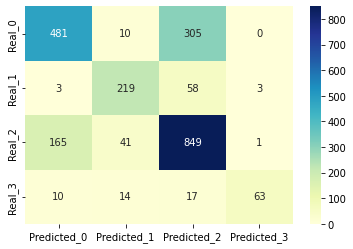

In [22]:
cm_matrix = pd.DataFrame(
    data=cm,
    columns=[f"Predicted_{i}" for i in range(len(cm))], 
    index=[f"Real_{i}" for i in range(len(cm))]
)

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# UNLABELED DATA
Now we face the real challenge: `unlabeled_data`

In [23]:
here = !pwd

challenge_data_path = path.join(path.dirname(here[0]), "unlabeled_data.csv")
challenge_data = eis_dataframe_from_csv(challenge_data_path)

In [24]:
challenge_data["len_freq"] = challenge_data["freq"].apply(lambda x: x.shape[0])
challenge_data["len_Z"] = challenge_data["Z"].apply(lambda x: x.shape[0])

In [25]:
challenge_data["Z_real"], challenge_data["Z_imag"] = complex_parts(challenge_data.Z)
#challenge_data["len_Z_real"] = challenge_data["Z_real"].apply(lambda x: x.shape[0])
#challenge_data["len_Z_imag"] = challenge_data["Z_imag"].apply(lambda x: x.shape[0])

challenge_data[["Z_real", "Z_imag"]]
#display(challenge_data.head())

#challenge_data["freq"][0].shape

,Z_real,Z_imag
0,"[107.98943481, 107.98943465, 107.98943442, 107...","[-1.91760783e-06, -2.69814865e-06, -3.79637798..."
1,"[1374.66297214, 1374.10472855, 1373.40544826, ...","[-5.24696677, -6.53835458, -8.14579098, -10.14..."
2,"[0.30615453, 0.30615039, 0.30614129, 0.3061213...","[-0.00051099, -0.00075703, -0.00112147, -0.001..."
3,"[185.15770678, 168.10345657, 144.77139506, 116...","[-55.35496519, -68.43230329, -79.23399855, -84..."
4,"[40238.7753, 40129.9244, 39956.838, 39675.02, ...","[-1100.82284, -1565.2135, -2220.09383, -3136.6..."
...,...,...
18563,"[62.14772073, 47.64383029, 36.62207005, 28.319...","[-92.1546178, -77.297139, -63.9647183, -52.393..."
18564,"[22.78791653, 22.78790763, 22.7878967, 22.7878...","[-3.955636e-05, -4.85689891e-05, -5.96246792e-..."
18565,"[699.42110996, 676.84357948, 649.12740737, 615...","[-88.73395903, -105.21733551, -122.95528022, -..."
18566,"[4356.04592034, 3306.44002566, 2514.71330434, ...","[-8696.39674, -6582.04052, -4980.63831, -3768...."


In [26]:
freq_interpolation = np.logspace(1.0, 5.0, num=100, base=10.0)
challenge_data["freq_interpolation"] = None
challenge_data["freq_interpolation"] = challenge_data["freq_interpolation"].apply(lambda x: freq_interpolation)

cols = []
for i in ["Z_real", "Z_imag"]:
    
    inter_p_col = f'{i}_interp'
    challenge_data[inter_p_col] = challenge_data.apply(lambda x: get_interpolating_function(x.freq, x[i]), axis=1)
    values_col = f'{i}_values'
    challenge_data[values_col] = challenge_data.apply(lambda x: eval_func(x.freq_interpolation, x[inter_p_col]), axis=1)
    cols.extend([inter_p_col, values_col])
 
    

In [27]:
challenge_data["Z_real_d1_values"] = challenge_data.apply(lambda x: nth_derivatives(x.freq_interpolation, x.Z_real_values, 2)[1], axis=1)    
challenge_data["Z_real_d2_values"] = challenge_data.apply(lambda x: nth_derivatives(x.freq_interpolation, x.Z_real_values, 2)[2], axis=1)
challenge_data["Z_imag_d1_values"] = challenge_data.apply(lambda x: nth_derivatives(x.freq_interpolation, x.Z_imag_values, 2)[1], axis=1)    
challenge_data["Z_imag_d2_values"] = challenge_data.apply(lambda x: nth_derivatives(x.freq_interpolation, x.Z_imag_values, 2)[2], axis=1)


In [30]:
cols= [
        'Z_real_values'
        ,'Z_real_d1_values'
        ,'Z_real_d2_values'
        ,'Z_imag_values'
        ,'Z_imag_d1_values'
        ,'Z_imag_d2_values'
    ]
#samples = challenge_data.sample(1000)
print(cols)
exploded_eis_data = challenge_data.explode(cols).reset_index()
print(f"shape exploded_data: {exploded_eis_data.shape}")
exploded_eis_data["idx"] = exploded_eis_data.groupby("index").transform("cumcount")
unstacked_dfs = []
exploded_cols = []
for c in cols:
    name_col = c + "_idx"
    name_template = c + "_{x:03d}"
    print(name_template)
    exploded_eis_data[name_col] = exploded_eis_data["idx"].apply(lambda x: name_template.format(x=int(x)))
    exploded_cols.extend(set(exploded_eis_data[name_col]))
    print(f"Total feature cols: {len(exploded_cols)}")
    exploded_eis_data[c] = exploded_eis_data[c].astype('float32')
    temp_df = exploded_eis_data.set_index(["index", name_col])[c].unstack()
    unstacked_dfs.append(temp_df)

res = challenge_data.join(unstacked_dfs)

['Z_real_values', 'Z_real_d1_values', 'Z_real_d2_values', 'Z_imag_values', 'Z_imag_d1_values', 'Z_imag_d2_values']
shape exploded_data: (1856800, 16)
Z_real_values_{x:03d}
Total feature cols: 100
Z_real_d1_values_{x:03d}
Total feature cols: 200
Z_real_d2_values_{x:03d}
Total feature cols: 300
Z_imag_values_{x:03d}
Total feature cols: 400
Z_imag_d1_values_{x:03d}
Total feature cols: 500
Z_imag_d2_values_{x:03d}
Total feature cols: 600


In [29]:
submission_pred =clf.predict(res[exploded_cols])
submission_pred

In [ ]:
inverse_reclasification